In [2]:
import nltk
import numpy as np
import json
import pickle
import timeit
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

In [3]:
devfile = "../A1_Data/dev.json"
trainfile = "../A1_Data/train.json"

### Training Phase

In [4]:
train_labels = []
f = open(trainfile,"r")
while(True):
    s = f.readline()
    if (s==""):
        break
    json_dump = json.loads(s)    
    train_labels.append(json_dump["ratings"])
f.close()

In [5]:
vectorizer = pickle.load(open("baseline_vectorizer.pickle","rb"))

In [6]:
feature_vector = pickle.load(open("baseline_tfidf_train_vector.pickle","rb"))

In [19]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(penalty="l2", multi_class='multinomial', solver="lbfgs", max_iter=1000)

In [20]:
start = timeit.default_timer()
model.fit(feature_vector[:100000], train_labels[:100000])
print(timeit.default_timer()-start)

55.58707322000009


In [11]:
pickle.dump(model,open("baseline_logist_model.pickle", "wb"))

### Some sanity checks

In [21]:
sanity_check = "Dishonest, untrustworthy, flaw-hiding dealership that is an embarrassment to the brand it bears"
check_vector = vectorizer.transform([sanity_check]).toarray()
model.predict(check_vector)[0]

1.0

In [22]:
sanity_check = "Excellent service. The staff is so friendly and always  willing to have conversations with their clients."
check_vector = vectorizer.transform([sanity_check]).toarray()
model.predict(check_vector)[0]

5.0

### Validation phase

In [23]:
dev_feature_vector = pickle.load(open("baseline_tfidf_dev_vector.pickle","rb"))

In [24]:
dev_labels = []
dev_data = []
f = open(devfile,"r")
while(True):
    s = f.readline()
    if (s==""):
        break
    json_dump = json.loads(s)    
    dev_labels.append(json_dump["ratings"])
    dev_data.append(json_dump["review"])
f.close()

In [25]:
conf_mat = np.zeros((5,5), dtype=int)
f = open("error_file","w")
for i in range(0,len(dev_labels),1000):
    fv = dev_feature_vector[i:i+1000].toarray()
    y_pred = model.predict(fv)
    conf_mat+= confusion_matrix(y_pred, dev_labels[i:i+1000])
    
    for p in range(1000):
        if  abs(y_pred[p]-dev_labels[i+p])>2:
            f.write("Gold: %.1f, Predicted: %.1f, Review: %s\n"%(dev_labels[i+p], y_pred[p], dev_data[i+p].replace('\n','\\n')))
conf_mat

array([[24698,  5581,  2027,   755,   912],
       [ 2494,  4497,  2380,   501,   194],
       [  886,  3633,  7874,  3321,   689],
       [  464,  1379,  7062, 20550,  9920],
       [ 1247,  1049,  2773, 18879, 76235]])

In [26]:
print("Accuracy: \t",conf_mat.trace()/len(dev_data))
score = 0
for i in range(5):
    for j in range(5):
        score+=conf_mat[i][j]*((i-j)**2)
print("Cost: \t\t",score)

Accuracy: 	 0.66927
Cost: 		 142992


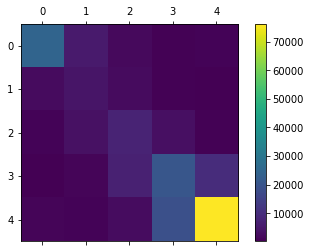

In [28]:
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat)
fig.colorbar(cax)
plt.savefig("Conf_Mat_Baseline.jpg")